# 12-Nature Tutorial- Binding Energy 

In [ ]:
#This code is at
#https://qiskit-community.github.io/qiskit-nature/tutorials/12_deuteron_binding_energy.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
#from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.observables_evaluator import estimate_observables
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA, QNSPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

from quantumrings.toolkit.qiskit import QrEstimatorV1 as Estimator

In [2]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)

In [3]:
def create_deuteron_hamiltonian(
    N: int, hbar_omega: float = 7.0, V_0: float = -5.68658111
) -> SparsePauliOp:
    """Creates a version of the Deuteron Hamiltonian as a qubit operator.

    Args:
        N (int): An integer number that represents the dimension of the
            basis.
        hbar_omega (float, optional): The value of the product of hbar and omega. Defaults to 7.0.
        V_0 (float, optional): The value of the potential energy. Defaults to -5.68658111.

    Returns:
        SparsePauliOp: The qubit-space Hamiltonian that represents the Deuteron.
    """
    hamiltonian_terms = {}
    for m in range(N):
        for n in range(N):

            label = "+_{} -_{}".format(str(n), str(m))
            coefficient_kinect = (hbar_omega / 2) * (
                (2 * n + 3 / 2) * kronecker_delta_function(n, m)
                - np.sqrt(n * (n + (1 / 2))) * kronecker_delta_function(n, m + 1)
                - np.sqrt((n + 1) * (n + (3 / 2)) * kronecker_delta_function(n, m - 1))
            )
            hamiltonian_terms[label] = coefficient_kinect

            coefficient_potential = (
                V_0 * kronecker_delta_function(n, 0) * kronecker_delta_function(n, m)
            )
            hamiltonian_terms[label] += coefficient_potential

    hamiltonian = FermionicOp(hamiltonian_terms, num_spin_orbitals=N)
    mapper = JordanWignerMapper()
    qubit_hamiltonian = mapper.map(hamiltonian)
    if not isinstance(qubit_hamiltonian, SparsePauliOp):
        qubit_hamiltonian = qubit_hamiltonian.primitive

    return qubit_hamiltonian

In [4]:
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, 5)]

In [5]:
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    print("Deuteron Hamiltonian: H_{}".format(i + 1))
    print(hamiltonian)
    print("\n")



Deuteron Hamiltonian: H_1
SparsePauliOp(['I', 'Z'],
              coeffs=[-0.21829055+0.j,  0.21829055+0.j])


Deuteron Hamiltonian: H_2
SparsePauliOp(['II', 'IZ', 'XX', 'YY', 'ZI'],
              coeffs=[ 5.90670945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j])


Deuteron Hamiltonian: H_3
SparsePauliOp(['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'XXI', 'YYI', 'ZII'],
              coeffs=[15.53170945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j, -3.91311896+0.j, -3.91311896+0.j, -9.625     +0.j])


Deuteron Hamiltonian: H_4
SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IXXI', 'IYYI', 'IZII', 'XXII', 'YYII', 'ZIII'],
              coeffs=[ 28.65670945+0.j,   0.21829055+0.j,  -2.14330352+0.j,  -2.14330352+0.j,
  -6.125     +0.j,  -3.91311896+0.j,  -3.91311896+0.j,  -9.625     +0.j,
  -5.67064811+0.j,  -5.67064811+0.j, -13.125     +0.j])




In [6]:
theta = Parameter(r"$\theta$")
eta = Parameter(r"$\eta$")

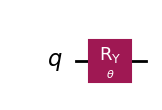

In [7]:
wavefunction = QuantumCircuit(1)
wavefunction.ry(theta, 0)
wavefunction.draw("mpl")

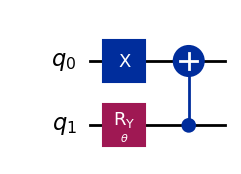

In [8]:
wavefunction2 = QuantumCircuit(2)
wavefunction2.x(0)
wavefunction2.ry(theta, 1)
wavefunction2.cx(1, 0)
wavefunction2.draw("mpl")

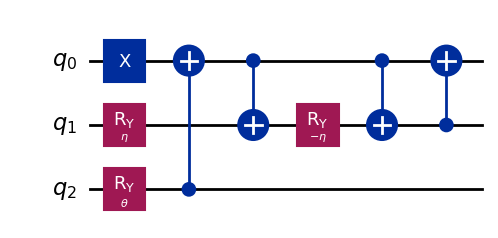

In [9]:
wavefunction3 = QuantumCircuit(3)
wavefunction3.x(0)
wavefunction3.ry(eta, 1)
wavefunction3.ry(theta, 2)
wavefunction3.cx(2, 0)
wavefunction3.cx(0, 1)
wavefunction3.ry(-eta, 1)
wavefunction3.cx(0, 1)
wavefunction3.cx(1, 0)
wavefunction3.draw("mpl")

In [10]:
ansatz = [wavefunction, wavefunction2, wavefunction3]

In [11]:
reference_values = []
print("Exact binding energies calculated through numpy.linalg.eigh \n")
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
    reference_values.append(eigenvalues[0])
    print("Exact binding energy for H_{}: {}".format(i + 1, eigenvalues[0]))

Exact binding energies calculated through numpy.linalg.eigh 

Exact binding energy for H_1: -0.43658110999999966
Exact binding energy for H_2: -1.7491598763215301
Exact binding energy for H_3: -2.0456708984064416
Exact binding energy for H_4: -2.143981030799861


In [12]:
print("Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper \n")
for i in range(3):
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}: {} MeV".format(i + 1, binding_energy))

Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper 

Binding energy for H_1: -0.43658110960995966 MeV
Binding energy for H_2: -1.7491595316396333 MeV
Binding energy for H_3: -2.04567089825919 MeV


In [13]:
def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [14]:
plots = []

for i in range(3):

    counts = []
    values = []
    params = []
    deviation = []
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=COBYLA(), callback=callback)
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots.append([counts, values])

"Evaluation: 45, Energy: -2.0456706360129235, Std: {'shots': 1024}"

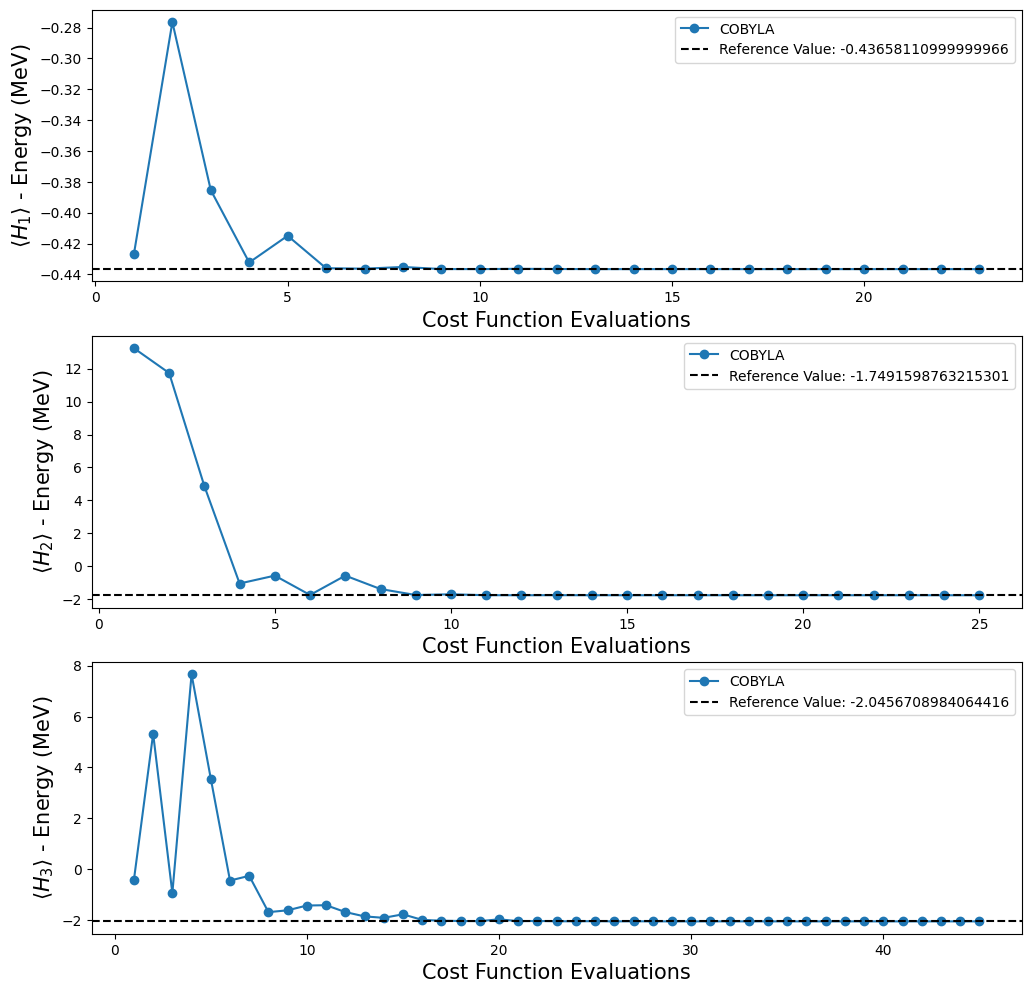

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches((12, 12))
for i, plot in enumerate(plots):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()

In [16]:
twolocal_ansatzes = []
for i in range(1, 5):
    ansatz = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        ["rz", "ry"],
        "cx",
        entanglement="full",
        reps=i,
        initial_state=None,
    )
    twolocal_ansatzes.append(ansatz)


In [17]:
print("Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz \n")
seed = 42
algorithm_globals.random_seed = seed
for i in range(4):
    vqe = VQE(Estimator(), ansatz=twolocal_ansatzes[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")

Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz 

Binding energy for H_1: -0.43658065601161367 MeV
Binding energy for H_2: -1.7491598677360036 MeV
Binding energy for H_3: -2.045670594916378 MeV
Binding energy for H_4: -2.143867103573763 MeV


In [18]:
seed = 42
algorithm_globals.random_seed = seed

plots_tl = []
for i in range(4):

    counts = []
    values = []
    params = []
    deviation = []
    vqe = VQE(
        Estimator(),
        ansatz=twolocal_ansatzes[i],
        optimizer=SLSQP(),
        callback=callback,
    )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots_tl.append([counts, values])


"Evaluation: 4148, Energy: -2.143867103581142, Std: {'shots': 1024}"

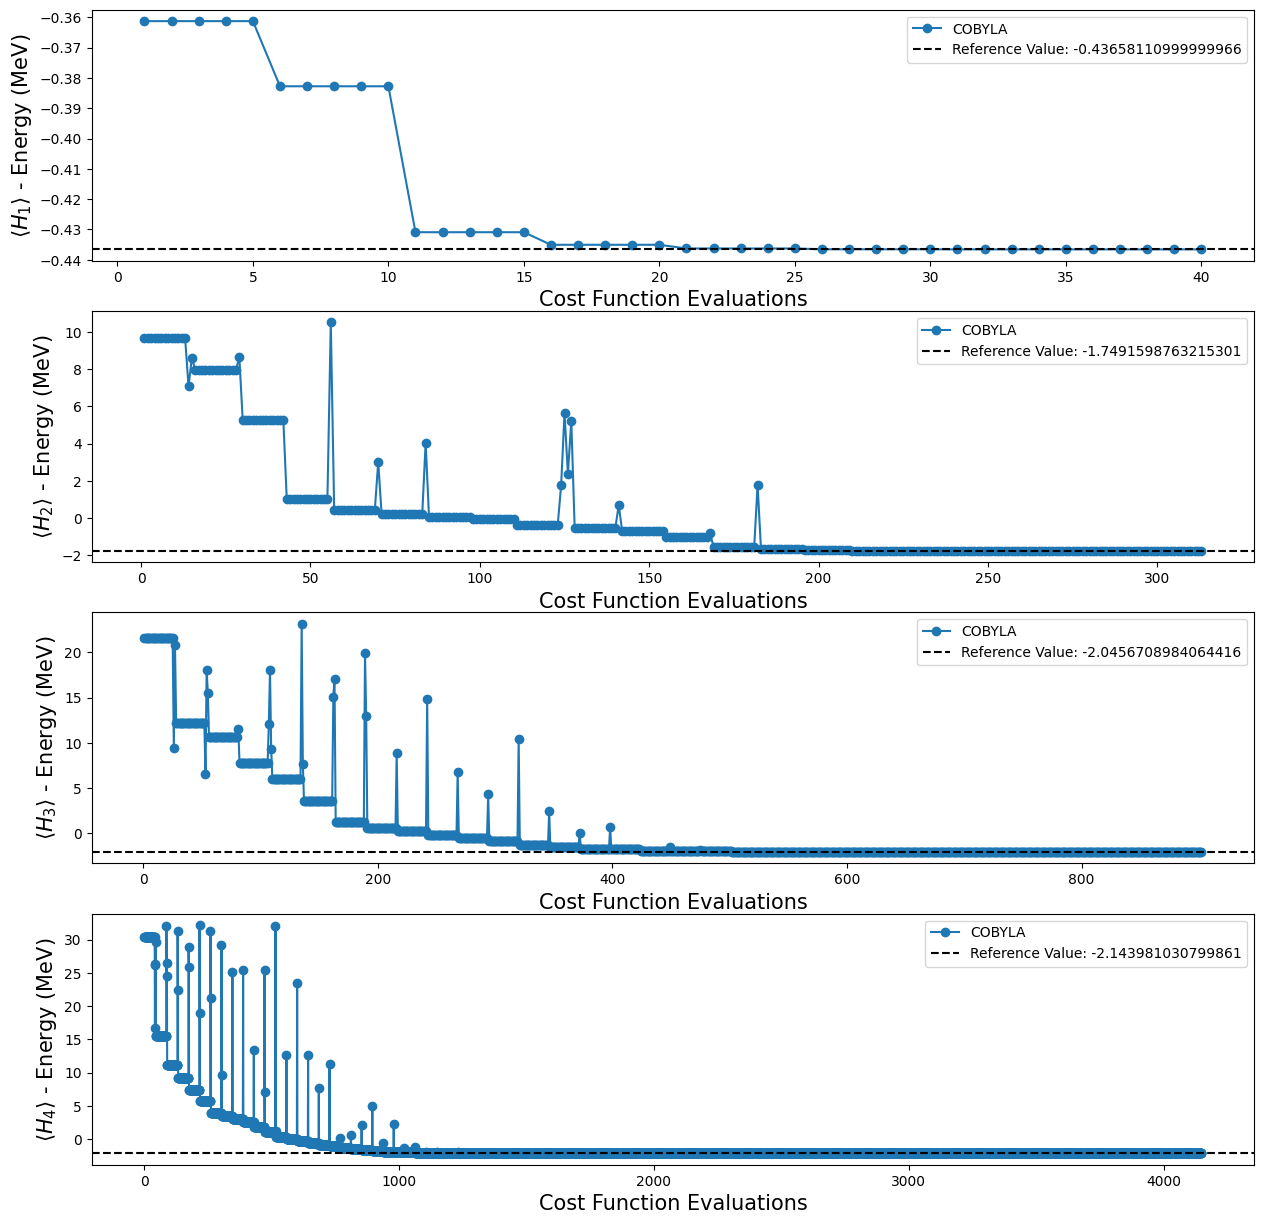

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches((15, 15))
for i, plot in enumerate(plots_tl):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()


In [20]:
def calculate_observables_exp_values(
    quantum_circuit: QuantumCircuit, observables: list, angles: list
) -> list:
    """Calculate the expectation value of an observable given the quantum
    circuit that represents the wavefunction and a list of parameters.

        Args:
            quantum_circuit (QuantumCircuit): A parameterized quantum circuit
            that represents the wavefunction of the system.

            observables (list): A list containing the observables that we want
            to know the expectation values.

            angles (list): A list with the values that will be used in the
            'assign_parameters' method.

        Returns:
            list_exp_values (list): A list containing the expectation values
            of the observables given as input.
    """
    list_exp_values = []
    for observable in observables:
        exp_values = []
        for angle in angles:
            qc = quantum_circuit.assign_parameters({theta: angle})
            result = estimate_observables(
                Estimator(),
                quantum_state=qc,
                observables=[observable],
            )

            exp_values.append(result[0][0])
        list_exp_values.append(exp_values)

    return list_exp_values

In [21]:
angles = list(np.linspace(-np.pi, np.pi, 100))
observables = [
    Pauli("IZ"),
    Pauli("ZI"),
    Pauli("XX"),
    Pauli("YY"),
    deuteron_hamiltonians[1],
]
h2_observables_exp_values = calculate_observables_exp_values(wavefunction2, observables, angles)

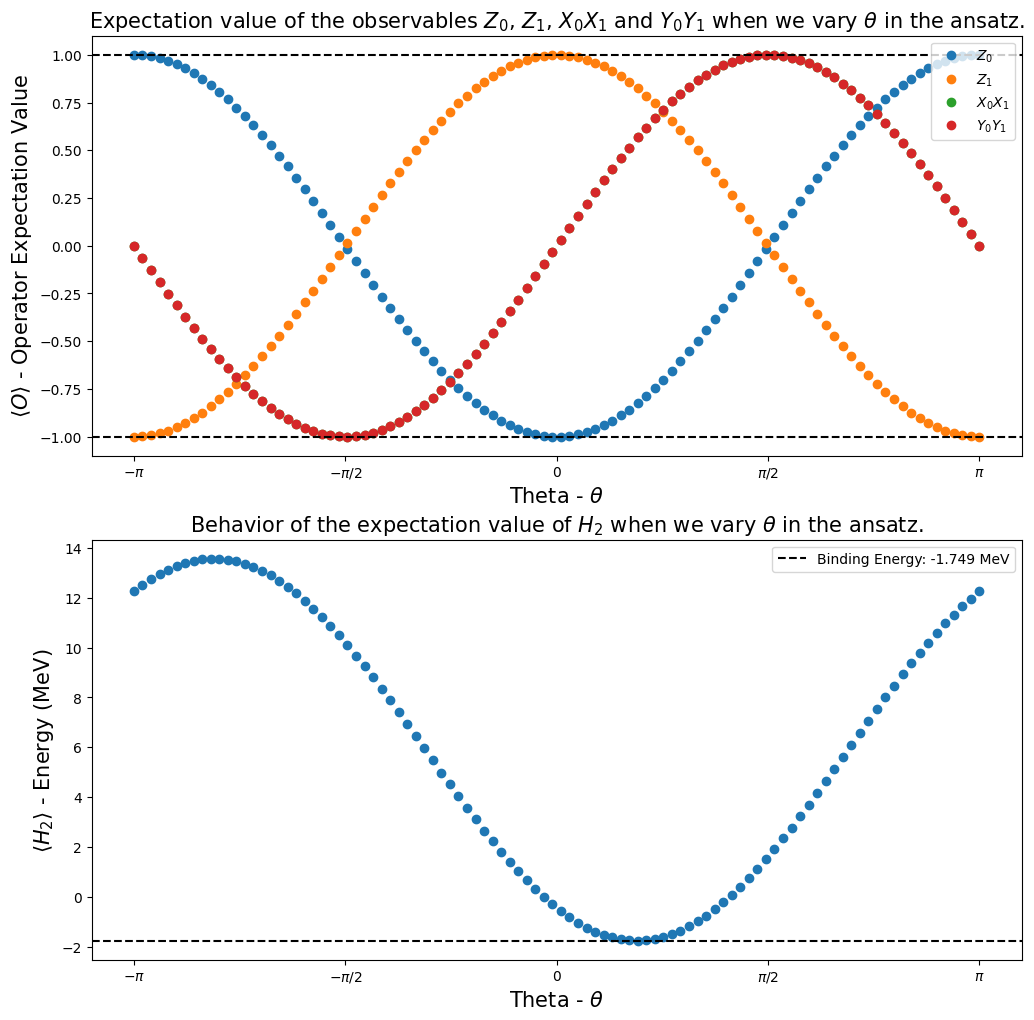

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches((12, 12))
ax[0].plot(angles, h2_observables_exp_values[0], "o", label=r"$Z_0$")
ax[0].plot(angles, h2_observables_exp_values[1], "o", label=r"$Z_1$")
ax[0].plot(angles, h2_observables_exp_values[2], "o", label=r"$X_0X_1$")
ax[0].plot(angles, h2_observables_exp_values[3], "o", label=r"$Y_0Y_1$")
ax[0].axhline(
    y=1,
    color="k",
    linestyle="--",
)
ax[0].axhline(y=-1, color="k", linestyle="--")
ax[0].legend()
ax[0].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[0].set_ylabel(r"$\langle O \rangle $ - Operator Expectation Value", fontsize=15)
ax[0].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[0].set_title(
    r"Expectation value of the observables $Z_0$, $Z_1$, $X_0X_1$ and $Y_0Y_1$ when we vary $\theta$ in the ansatz.",
    fontsize=15,
)
ax[1].plot(angles, h2_observables_exp_values[4], "o")
ax[1].axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Binding Energy: {} MeV".format(np.round(reference_values[1], 3)),
)
ax[1].legend()
ax[1].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[1].set_ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)", fontsize=15)
ax[1].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[1].set_title(
    r"Behavior of the expectation value of $H_2$ when we vary $\theta$ in the ansatz.", fontsize=15
)

plt.show()